## Code for lstm network development. data preparation for lstm can be found in preprocess/seqdata.ipynb

In [1]:
import pandas as pd
import numpy as np
import time
import keras
from math import ceil
import time
import random
import glob,os
import matplotlib.pyplot as plt
import pickle
import pdb
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Embedding, Masking, Dropout
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import seaborn as sns

import matplotlib.animation as animation


Using TensorFlow backend.
/home/arash/anaconda3/envs/gpusupport/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arash/anaconda3/envs/gpusupport/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arash/anaconda3/envs/gpusupport/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arash

### Load Data

In [2]:
with open('/home/arash/ProjectVR/cleaneddata/seperateddata/inputseqtrain', 'rb') as f:
    inputseqtrain = pickle.load(f) 

with open('/home/arash/ProjectVR/cleaneddata/seperateddata/ytrain', 'rb') as f:
    ytrain = pickle.load(f) 
with open('/home/arash/ProjectVR/cleaneddata/seperateddata/inputseqTEST', 'rb') as f:
    inputseqTEST = pickle.load(f) 
with open('/home/arash/ProjectVR/cleaneddata/seperateddata/ytest', 'rb') as f:
    ytest = pickle.load(f) 

In [158]:
with open('/home/arash/ProjectVR/cleaneddata/seperateddata/inputseqtrain0_5', 'rb') as f:
    inputseqtrain = pickle.load(f) 
with open('/home/arash/ProjectVR/cleaneddata/seperateddata/ytrain0_5', 'rb') as f:
    ytrain = pickle.load(f) 
with open('/home/arash/ProjectVR/cleaneddata/seperateddata/inputseqTEST0_5', 'rb') as f:
    inputseqTEST = pickle.load(f) 
with open('/home/arash/ProjectVR/cleaneddata/seperateddata/ytest0_5', 'rb') as f:
    ytest = pickle.load(f) 

### Define Vanilla Model

In [3]:
class VanillaLSTM(BaseEstimator):
    
    def __init__(self, nodes=50, batch_size=32,
                 epochs=200, Llayers=1, features=5, steps_in=0, steps_out=0
                 ):

        self.nodes = nodes
        self.batch_size = batch_size
        self.epochs = epochs
        self.Llayers= Llayers
        self.features = features
        self.steps_in = steps_in
        self.steps_out = steps_out
        self.maxXY=654.7
        self.minXY=650.1


    def create_model(self):
        model = Sequential()
        model.add(Masking(mask_value=-0.01, input_shape=(self.steps_in, self.features)))
        for i in range(self.Llayers-1):
            model.add(LSTM(self.nodes, activation='relu', return_sequences=True))
        model.add(LSTM(self.nodes, activation='relu'))
        model.add(Dense(self.steps_out))
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def fit(self,inputseq,y):
        start = time.time()
        X = inputseq[:,:,:self.features]
        self.model=self.create_model()
        self.model.fit(X, y, epochs = self.epochs, verbose = 0, batch_size = self.batch_size)
        end = time.time()
        print ("Finished Fitting Model. # of Epochs: %d\n Time Taken : %d secs"
               % (self.epochs,end - start))
        return self
    
    def predict(self, inputseq):
        X = inputseq[:,:,:self.features]
        
        return self.model.predict(X)
    
    def score(self,inputseq,y):
        
        X = inputseq[:,:,:self.features]
        ypred = self.predict(inputseq)
        yinv = np.zeros(y.shape)
        ypredinv = np.zeros(ypred.shape)
        for i in range(len(y)):
            pos = sum (n>=0 for n in y[i])                #position of the last actual value on y, not padded
            yinv[i][:pos]= y[i][:pos] * (self.maxXY-self.minXY) + self.minXY
            ypredinv[i][:pos] = ypred[i][:pos]* (self.maxXY-self.minXY) + self.minXY
            
        rmseScore = -sqrt(mean_squared_error(ypredinv, yinv))    #negative of RMSE

        return rmseScore
        

### fitting Vanilla LSTM, using grid search for hypperparameters

In [ ]:
n_features = (inputseqtrain.shape[2]-1)
n_steps_in=inputseqtrain.shape[1]
n_steps_out=ytrain.shape[1]

VLmodel=VanillaLSTM(epochs=100, features=n_features, Llayers=2,
                    steps_in=n_steps_in, steps_out=n_steps_out)

In [ ]:
tuned_params = {"Llayers" : [2,3]}#{"nodes" : [10,50,100],"batch_size": [32,64,128] ,"Llayers" : [1,2,3]}

gs = GridSearchCV(VLmodel, tuned_params,cv = 8, refit= True, n_jobs=2)

In [ ]:
np.load('/home/arash/ProjectVR/models/trainedmodels/VLSTM1.pkl',allow_pickle=True)      


In [ ]:
grid_result=gs.fit(inputseqtrain,ytrain)

In [ ]:
np.save('/home/arash/ProjectVR/models/GridResults/VLSTM400_8_50_32_L.npy',grid_result.cv_results_)      
#filename: ModelnameEpochs_CV_Nodes_Batch_changingparameters (L:LLayers)

In [ ]:
bestVLSTM = grid_result.best_estimator_

In [ ]:
joblib.dump(bestVLSTM, '/home/arash/ProjectVR/models/trainedmodels/VLSTM1.pkl')

In [ ]:
bestVLSTM.score(inputseqTEST,ytest)

In [ ]:
VLmodel.fit(inputseqtrain,ytrain)

In [ ]:
VLmodel.score(inputseqTEST,ytest)

In [ ]:
history = bestVLSTM.model.history.history
# plot history
plt.plot(history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


## lstm model with aux variables

In [4]:
class AuxLSTM(BaseEstimator):
    
    def __init__(self, nodes=50, batch_size=32,
                 epochs=200, Dlayers=1, Llayers=1, features=5, steps_in=0, steps_out=0, drpout=0.5
                 ):

        self.nodes = nodes
        self.features = features
        self.steps_in = steps_in
        self.steps_out = steps_out
        self.epochs = epochs
        self.batch_size = batch_size
        self.Dlayers= Dlayers   #number of hidden dense layers
        self.Llayers = Llayers  #number of lstm layers
        self.maxXY=654.7
        self.minXY=650.1
        self.drpout=drpout


    def create_model(self):
        
        seq_input = Input(shape=(self.steps_in, self.features), dtype='float32', name='seq_input')
        mask = Masking(mask_value=-0.01)(seq_input)
        if self.Llayers==1:
            
            lstm_out = LSTM(self.nodes, activation='relu')(mask)
            
        else:
            lstm_out = LSTM(self.nodes,activation='relu',return_sequences=True)(mask)
            
            for i in range(self.Llayers-2):
                lstm_out = LSTM(self.nodes,activation='relu',return_sequences=True)(lstm_out)
                
            lstm_out = LSTM(self.nodes, activation='relu')(lstm_out)

        #output for lstm, corresponds to 0.2 of loss, used to smooth training and regularization:
        auxiliary_output = Dense(self.steps_out, activation='sigmoid' ,name='aux_output')(lstm_out)   

        auxiliary_input = Input(shape=(14,), name='aux_input')
        x = keras.layers.concatenate([lstm_out, auxiliary_input])

        # We stack a deep densely-connected network on top
        for i in range(self.Dlayers):
            x = Dense(self.nodes, activation='relu')(x)
            if self.drpout>0:
                x = Dropout(self.drpout)(x)

        # And finally we add the main logistic regression layer
        main_output = Dense(self.steps_out, activation='sigmoid', name='main_output')(x)

        modelaux = Model(inputs=[seq_input, auxiliary_input], outputs=[main_output, auxiliary_output])


        modelaux.compile(optimizer='adam', loss='mse',
                      loss_weights=[1., 0.2])
        return modelaux
    
    def fit(self,inputseq,y):
        start = time.time()
        X = inputseq[:,:,:self.features]
        aux=inputseq[:,:,self.features][:,:14]      
        self.model=self.create_model()
        self.model.fit([X,aux], [y,y], epochs = self.epochs, verbose = 0, batch_size = self.batch_size)
        end = time.time()
        print ("Finished Fitting AuxModel. # of Epochs: %d\n Time Taken : %d secs"
               % (self.epochs,end - start))
        return self
    
    def predict(self, inputseq):
        X = inputseq[:,:,:self.features]
        aux=inputseq[:,:,self.features][:,:14]
        
        return self.model.predict([X,aux])
    
    def score(self,inputseq,y):
        X = inputseq[:,:,:self.features]
        aux = inputseq[:,:,self.features][:,:14]    
        ypred = self.predict(inputseq)[0]        #auxlstm has two identical outputs, 1st in chosen
        yinv = np.zeros(y.shape)
        ypredinv = np.zeros(ypred.shape)
        for i in range(len(y)):
            pos = sum (n>=0 for n in y[i])                #position of the last actual value on y, not padded
            yinv[i][:pos]= y[i][:pos] * (self.maxXY-self.minXY) + self.minXY
            ypredinv[i][:pos] = ypred[i][:pos]* (self.maxXY-self.minXY) + self.minXY
            
        rmseScore = -sqrt(mean_squared_error(ypredinv, yinv))    #negative of RMSE
        return rmseScore
        

In [ ]:
n_features = (inputseqtrain.shape[2]-1)
n_steps_in=inputseqtrain.shape[1]
n_steps_out=ytrain.shape[1]

Auxmodel=AuxLSTM(epochs=1000, features=n_features,
                    steps_in=n_steps_in, steps_out=n_steps_out)
 

In [ ]:
tuned_params = {'drpout': [0,0.5],"Dlayers" : [1], "Llayers" : [2]}
               # 'batch_size' : [64], 'nodes': [100]  }

gsaux = GridSearchCV(Auxmodel, tuned_params,cv = 5, refit= True, n_jobs=-1)

In [ ]:
gridaux_result=gsaux.fit(inputseqtrain,ytrain)

In [ ]:
gridaux_result.cv_results_

In [ ]:
np.save('/home/arash/ProjectVR/models/GridResults/Aux0_5LSTM001.npy',gridaux_result.cv_results_)
bestauxLSTM = gridaux_result.best_estimator_

In [ ]:
joblib.dump(bestauxLSTM, '/home/arash/ProjectVR/models/trainedmodels/Aux0_5LSTM6.pkl')
bestauxLSTM.score(inputseqTEST,ytest)

In [ ]:
X = inputseqtrain[:,:,:5]
aux = inputseqtrain[:,:,:5][:,:14]    
ypred = Aux1Best.predict(inputseqtrain)[1]        #auxlstm has two identical outputs, 1st in chosen
yinv = np.zeros(ytrain.shape)
ypredinv = np.zeros(ypred.shape)
for i in range(len(ytrain)):
     pos = sum (n>=0 for n in ytrain[i])                #position of the last actual value on y, not padded
     yinv[i][:pos]= ytrain[i][:pos] * (654.7-650.4) + 650.4
     ypredinv[i][:pos] = ypred[i][:pos]* (654.7-650.4) + 650.4
rmseScore = -sqrt(mean_squared_error(ypredinv, yinv))    #negative of RMSE


In [ ]:
aux1=np.load('/home/arash/ProjectVR/models/GridResults/AuxLSTM00L.npy',allow_pickle=True)

In [ ]:
np.zeros((1,10))

In [ ]:
len(inputseqtrain[0])

In [ ]:
Aux1Best=AuxLSTM(epochs=1000, features=n_features,
                    steps_in=n_steps_in, steps_out=n_steps_out,Llayers=2,Dlayers=1,drpout=0.5,
                   batch_size=32, nodes=50)

In [ ]:
Aux2Best=AuxLSTM(epochs=100, features=n_features,
                    steps_in=n_steps_in, steps_out=n_steps_out,Llayers=2,Dlayers=1,drpout=0.5,
                   batch_size=32, nodes=50)

# Animation Creation

In [ ]:
bestaux=joblib.load('/home/arash/ProjectVR/models/trainedmodels/AuxLSTM2.pkl')

In [52]:
bestvlstm=joblib.load('/home/arash/ProjectVR/models/trainedmodels/VLSTM1.pkl')

In [ ]:
bestaux.score(inputseqtrain,ytrain)

In [6]:
bestaux0_5=joblib.load('/home/arash/ProjectVR/models/trainedmodels/Aux0_5LSTM6.pkl')

-0.2666871975202515

In [ ]:
maxXY=654.7
minXY=650.1

In [46]:
num=1

In [77]:
ypred = bestaux.predict(inputseqtrain)[0][num]        #auxlstm has two identical outputs, 1st in chosen
ypredvlstm=bestvlstm.predict(inputseqtrain)[num] 


pos = sum (n>=0 for n in ytrain[num])                #position of the last actual value on y, not padded

title= "X Coordinate"
y= ypred[:pos]* (maxXY-minXY) + minXY
x = np.arange(0,len(y)/10,0.1)
xv=x
yv=ypredvlstm[:pos]* (maxXY-minXY) + minXY

ytrue = ytrain[num][:pos] * (maxXY-minXY) + minXY
xtrue = x

In [78]:
def augment(xold,yold,numsteps):
    xnew = []
    ynew = []
    for i in range(len(xold)-1):
        difX = xold[i+1]-xold[i]
        stepsX = difX/numsteps
        difY = yold[i+1]-yold[i]
        stepsY = difY/numsteps
        for s in range(numsteps):
            xnew = np.append(xnew,xold[i]+s*stepsX)
            ynew = np.append(ynew,yold[i]+s*stepsY)
    return xnew,ynew

In [79]:
x,y=augment(x,y,10)
xv,yv=augment(xv,yv,10)
xtrue,ytrue=augment(xtrue,ytrue,10)


In [80]:
true0=pd.DataFrame(ytrue,xtrue)
pred0=pd.DataFrame(y,x)
Vpred0=pd.DataFrame(yv,xv)
true0.columns = {title}

pred0.columns={title}
Vpred0.columns={title}

plt.rcParams['animation.ffmpeg_path'] = '/home/arash/anaconda3/envs/gpusupport/bin/ffmpeg'    

In [143]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Arash'), bitrate=1800)

<IPython.core.display.Javascript object>


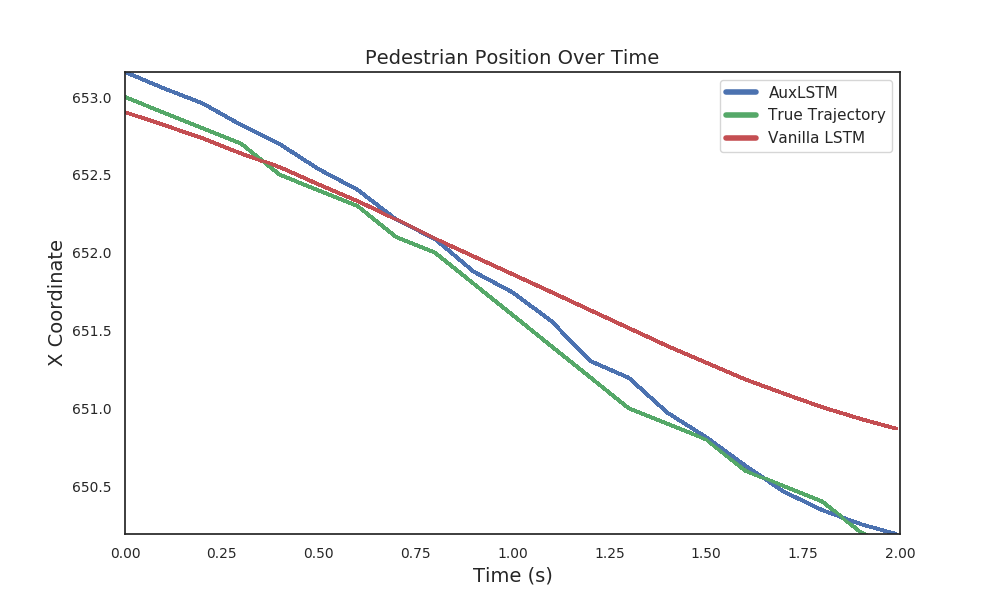

In [156]:
%matplotlib notebook
fig = plt.figure(figsize=(10,6))
plt.xlim(0, len(x)/100)
plt.ylim(np.min(pred0)[0], np.max(pred0)[0])
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel(title,fontsize=14)
plt.title('Pedestrian Position Over Time',fontsize=14)
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='r', lw=4)]
plt.legend(custom_lines, ['AuxLSTM', 'True Trajectory', 'Vanilla LSTM'])

In [153]:
def animate(i):
    dataaux = pred0.iloc[:int(i+1)] #select data range
    datatrue = true0.iloc[:int(i+1)] #select data range
    dataV=Vpred0.iloc[:int(i+1)] #select data range
    p = sns.lineplot(x=dataaux.index, y=dataaux[title], data=dataaux,markers=True,color="b")
    p2 = sns.lineplot(x=datatrue.index, y=datatrue[title], data=datatrue, markers=True,color="g")
    p3 = sns.lineplot(x=dataV.index, y=dataV[title], data=dataV, markers=True,color="r")
    sns.set_style("white")
    p.tick_params(labelsize=10)
    p2.tick_params(labelsize=10)
    p3.tick_params(labelsize=10)
    plt.setp(p.lines,linewidth=2)
    plt.setp(p2.lines,linewidth=2)

In [157]:
ani = animation.FuncAnimation(fig, animate,frames=400 ,repeat=True)

ani.save('Sample03.mp4', writer=writer)